In [14]:
import pandas as pd
import numpy as np
import re
from scipy.stats import chisquare
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import chisquare          # χ² goodness-of-fit
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats

Observed counts by option-set size:
 chosen_pos    1   2   3  4
num_options               
2            18  22   0  0
3             6  17  17  0
4            11  12   9  8 



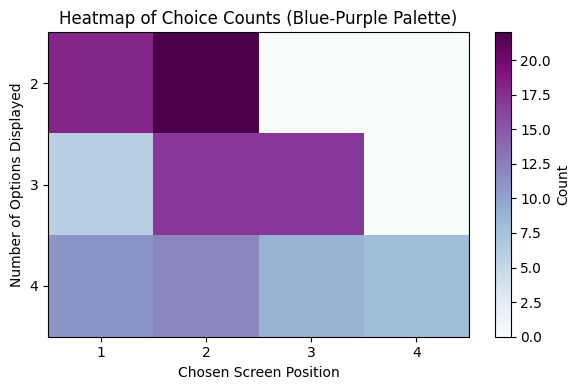

In [10]:
df = pd.read_csv("processed_pilot_data/main_trials.csv")
# ────────────────────────────────────────────────────────────────
#  Parse key trial-level variables
# ────────────────────────────────────────────────────────────────
# a) numeric position that was clicked (1…4)
df["chosen_pos"] = df["Position"].str.extract(r"(\d+)").astype(int)

# b) number of discounts shown on that screen
df["num_options"] = df["Display"].str.extract(r"(\d)").astype(int)

# ────────────────────────────────────────────────────────────────
#  Descriptive frequency table
# ────────────────────────────────────────────────────────────────
freq = (
    df.groupby(["num_options", "chosen_pos"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)
print("Observed counts by option-set size:\n", freq, "\n")

plt.figure(figsize=(6, 4))
plt.imshow(freq.values, aspect='auto', cmap='BuPu')
plt.colorbar(label='Count')

plt.xticks(np.arange(freq.shape[1]), freq.columns)
plt.yticks(np.arange(freq.shape[0]), freq.index)
plt.xlabel('Chosen Screen Position')
plt.ylabel('Number of Options Displayed')
plt.title('Heatmap of Choice Counts (Blue‑Purple Palette)')

plt.tight_layout()
plt.show()

In [8]:
# ────────────────────────────────────────────────────────────────
#  χ² test: is the overall distribution across positions uniform?
# ────────────────────────────────────────────────────────────────
print("Chi-square goodness-of-fit (uniform expectation):")
for n, row in freq.iterrows():
    obs = row.values[:n]                               # keep valid positions
    exp = np.repeat(obs.sum() / len(obs), len(obs))    # equal probability
    chi2, p = chisquare(obs, f_exp=exp)
    print(f"  {n} options → χ²({len(obs)-1}) = {chi2:.2f},  p = {p:.3f}")


Chi-square goodness-of-fit (uniform expectation):
  2 options → χ²(1) = 0.40,  p = 0.527
  3 options → χ²(2) = 6.05,  p = 0.049
  4 options → χ²(3) = 1.00,  p = 0.801


In [9]:
# ────────────────────────────────────────────────────────────────
#   Direct test of “earlier / central” bias
#       • bias positions = Position 1  OR  the strict centre
#       (for even N, the left-central position N/2)
# ────────────────────────────────────────────────────────────────
def central_pos(n):            # left-centre when N is even
    return (n + 1) // 2 if n % 2 else n // 2

df["is_bias_pos"] = df.apply(
    lambda r: (r["chosen_pos"] == 1) or (r["chosen_pos"] == central_pos(r["num_options"])),
    axis=1,
)

print("\nOne-sided z-tests vs. chance for bias positions:")
for n, grp in df.groupby("num_options"):
    succ   = grp["is_bias_pos"].sum()
    total  = len(grp)
    k_bias = 1 + (central_pos(n) != 1)          # # of bias spots (1 or 2)
    p0     = k_bias / n                         # chance level
    z, p   = proportions_ztest(succ, total, value=p0, alternative="larger")
    print(
        f"  {n} options → {succ}/{total} bias choices "
        f"(p̂ = {succ/total:.2f},  p₀ = {p0:.2f})  z = {z:.2f},  p = {p:.3f}"
    )


One-sided z-tests vs. chance for bias positions:
  2 options → 18/40 bias choices (p̂ = 0.45,  p₀ = 0.50)  z = -0.64,  p = 0.737
  3 options → 23/40 bias choices (p̂ = 0.57,  p₀ = 0.67)  z = -1.17,  p = 0.880
  4 options → 23/40 bias choices (p̂ = 0.57,  p₀ = 0.50)  z = 0.96,  p = 0.169


In [15]:
# Cross‑tab: Position × Deal Type
crosstab = (
    df.groupby(['Deal Type', 'chosen_pos'])
      .size()
      .unstack(fill_value=0)
      .rename_axis(columns='Position')
)
print("Counts by deal type and position:")
print(crosstab.to_string())
print("\n")


Counts by deal type and position:
Position         1   2   3  4
Deal Type                    
BOGO             6   4   4  3
Dollar off       6   9   3  1
Now price        4  12   6  3
Percentage off  19  26  13  1




We can see that the discout frame is not evenly distributed in the four positions when we look together. And in the descriptive study, 60% participants choose percentage off.

In [21]:
def central_pos(n):
    return (n + 1) // 2 if n % 2 else n // 2

df['is_bias_pos'] = df.apply(
    lambda r: (r['chosen_pos'] == 1) or (r['chosen_pos'] == central_pos(r['num_options'])),
    axis=1,
)
df = df.rename(columns={'Reaction Time': 'Reaction_Time', 'Deal Type': 'Deal_Type'})
model = smf.glm(
    'is_bias_pos ~ C(num_options) + C(Deal_Type) + Reaction_Time',
    data=df,
    family=sm.families.Binomial()
).fit()
print(model.summary())

                              Generalized Linear Model Regression Results                              
Dep. Variable:     ['is_bias_pos[False]', 'is_bias_pos[True]']   No. Observations:                  120
Model:                                                     GLM   Df Residuals:                      113
Model Family:                                         Binomial   Df Model:                            6
Link Function:                                           Logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -81.622
Date:                                         Wed, 21 May 2025   Deviance:                       163.24
Time:                                                 14:37:57   Pearson chi2:                     120.
No. Iterations:                                              4   Pseudo R-squ. (CS):            0.02125
Covariance Type:                                     nonrobust  

In [23]:
# ANOVA: Reaction Time by chosen position
anova_res = stats.f_oneway(
    *[df.loc[df.chosen_pos == p, 'Reaction_Time'] for p in sorted(df.chosen_pos.unique())]
)
print("\nReaction Time ~ Position ANOVA F =", round(anova_res.statistic, 2), 
      "p =", round(anova_res.pvalue, 4))



Reaction Time ~ Position ANOVA F = 2.49 p = 0.0638


In [24]:
# ANOVA:  Likely‑to‑buy by chosen position
anova_res = stats.f_oneway(
    *[df.loc[df.chosen_pos == p, 'Likely to buy'] for p in sorted(df.chosen_pos.unique())]
)
print("\nLikely to buy ~ Position ANOVA F =", round(anova_res.statistic, 2), 
      "p =", round(anova_res.pvalue, 4))


Likely to buy ~ Position ANOVA F = 0.45 p = 0.7159


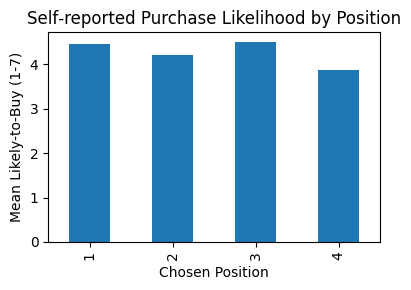

In [20]:
# Plot Likely‑to‑buy by position
means = df.groupby('chosen_pos')['Likely to buy'].mean()
plt.figure(figsize=(4,3))
means.plot(kind='bar')
plt.xlabel('Chosen Position')
plt.ylabel('Mean Likely‑to‑Buy (1‑7)')
plt.title('Self‑reported Purchase Likelihood by Position')
plt.tight_layout()
plt.show()